In [1]:
import numpy as np
np.random.seed(6)
from pybedtools import BedTool
import pybedtools
import pandas as pd
import seaborn as sns

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout,BatchNormalization,Activation
from keras.layers import Conv1D, MaxPooling1D,Conv2D,MaxPooling2D,GlobalAveragePooling1D, AveragePooling1D
from keras.layers import Dropout
from keras.optimizers import Adam,RMSprop
from keras import regularizers as kr
from keras import initializers
from keras.callbacks import EarlyStopping
from keras.utils import np_utils, to_categorical
# custom R2-score metrics for keras backend
from tensorflow.python.keras import backend as K
import matplotlib.pyplot as plt

import os
from sklearn.metrics import r2_score
from tensorflow.python.keras.callbacks import EarlyStopping

/home/AD/h5li/.local/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#parameter setting...
cell_type = 5
apply_sample_weight = False
target_length = 200
filter_length = 6

In [3]:
def read_data(bed_file,fasta_file):
    #apply bedtools to read fasta files '/home/h5li/methylation_DMR/data/DMR_coordinates_extended_b500.bed'
    a = pybedtools.example_bedtool( bed_file )
    # '/home/h5li/methylation_DMR/data/mm10.fasta'
    fasta = pybedtools.example_filename( fasta_file )
    a = a.sequence(fi=fasta)
    seq = open(a.seqfn).read()
    #read and extract DNA sequences 
    DNA_seq_list = seq.split('\n')
    DNA_seq_list.pop()
    DNA_seq = []
    m = 10000
    n = 0
    for index in range(len(DNA_seq_list)//2):
        DNA_seq.append(DNA_seq_list[index*2 + 1].upper())
        if len(DNA_seq_list[index*2 + 1]) < m:
            m = len(DNA_seq_list[index*2 + 1])
        if len(DNA_seq_list[index*2 + 1]) > n:
            n = len(DNA_seq_list[index*2 + 1])
    print('The shortest length of DNA sequence is {0}bp'.format(m))
    print('The longest length of DNA sequence is {0}bp'.format(n))
    print('Total Number of input sequence is {0}'.format(len(DNA_seq)))
    return DNA_seq,n,m

In [4]:
def extend_Data(targetLength,dnaSeqList):
    newDNAList = []
    for seq in dnaSeqList:
        if len(seq) < targetLength:
            diff = targetLength - len(seq)
            if diff % 2 == 0:
                seq += 'N' * (diff//2)
                seq = 'N' * (diff//2) + seq
            if diff % 2 ==1:
                seq += 'N' *(diff//2)
                seq = 'N' * (diff//2 + 1) + seq
        newDNAList.append(seq)
    return newDNAList

def chop_Data(targetLength,dnaSeqList):
    #chop DNA sequences to have same length
    Uni_DNA = []
    for s in dnaSeqList:
        if len(s) < targetLength:
            print('Exceptions!')
        diff = len(s) - targetLength
        if diff % 2 == 0:
            side = diff // 2
            Uni_DNA.append(s[side:-side])
        else:
            right = diff // 2
            left = diff// 2 + 1
            Uni_DNA.append(s[left:-right])
    return Uni_DNA

In [5]:
#below are helper methods
def data_aug(seq):
    new_seq = []
    for i in range(len(seq)):
        l = seq[i]
        if l == 'A':
            new_seq.append( 'T' )
        elif l == 'C':
            new_seq.append( 'G' )
        elif l == 'G':
            new_seq.append( 'C' )
        elif l == 'T':
            new_seq.append( 'A' )
        else:
            new_seq.append( 'N' )
    return new_seq

def data_rev(seq):
    new_seq = [None] * len(seq)
    for i in range(len(seq)):
        new_seq[-i] = seq[i]
    return new_seq      

def mse_keras(y_true, y_pred):
    SS_res =  K.sum( K.square( y_true - y_pred ) ) 
    SS_tot = K.sum( K.square( y_true - K.mean( y_true ) ) ) 
    return ( SS_res/SS_tot)

def R2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot) )

In [6]:
def preprocess_data(DNA_seq):

    train_size = len(DNA_seq)

    #One hot encoding 
    DNA = []
    for u in DNA_seq:
        sequence_vector = []
        for c in u:
            if c == 'A':
                sequence_vector.append([1,0,0,0])
            elif c == 'C':
                sequence_vector.append([0,1,0,0])
            elif c == 'G':
                sequence_vector.append([0,0,1,0])
            else:
                sequence_vector.append([0,0,0,1])
        #print(np.array(sequence_vector).shape)
        DNA.append(np.array(sequence_vector))
    DNA = np.array(DNA)
    print(DNA.shape)
    return DNA

In [7]:
def Formalize_Data(DNA_seq, methylation_file, cell_type):
    #Read Methylation level
    labels = list(pd.read_csv(methylation_file,header = None)[cell_type])
    train_labels = np.array(labels)
    training_seq_shape = (len(DNA_seq),len(DNA_seq[0]),4)
    train_data = DNA_seq.reshape(training_seq_shape)
    return train_data,train_labels

In [8]:
bed_file_path = '/home/h5li/methylation_DMR/data/DMR_coordinates_extended_b500.bed'
fasta_file_path = '/home/h5li/methylation_DMR/data/mm10.fasta'
methylation_file_path = '../../data/Mouse_DMRs_methylation_level.csv'
total_counts_file_path ='../../data/Mouse_DMRs_counts_total.csv'
methy_counts_file_path = '../../data/Mouse_DMRs_counts_methylated.csv'
    
DNA_seq,long_length,short_length = read_data(bed_file_path, fasta_file_path)   

The shortest length of DNA sequence is 1407bp
The longest length of DNA sequence is 5829bp
Total Number of input sequence is 58959


In [9]:
DNA_seq = chop_Data(target_length,DNA_seq)

In [11]:
#This Part of code id used to check the validity of CNN architecture

#We plan to start from single pattern in DNA sequence and the DNA methylation level is 0 or 1.
#Then we try with the same pattern and we use a random normal distribution to evaluate the
#methylation level to further simulate the DMR regions


# single pattern starts from here

# find out the most common patter first
'''Kmers_count = pd.read_csv('/cndd/emukamel/snmCSeq/DMR/Kmer_Features/Kmers_K{}_counts.csv'.format(filter_length),header = None)
Kmers_count = Kmers_count.drop([0],axis = 1)

maxNum = 0
maxIndex = 0
for n in Kmers_count.columns:
    if Kmers_count[n].sum() > maxNum:
        maxNum = Kmers_count[n].sum()
        maxIndex = n - 1
print(maxIndex, maxNum)'''

#targetKmers = pd.read_csv('/cndd/emukamel/snmCSeq/DMR/Kmer_Features/Kmers_K{}_sequences.csv'.format(filter_length),header = None)[0]
import random
#targetIndex = []
#for i in range(10):
#    targetIndex.append(random.randint(0,len(targetKmers)))
#targetKmers += 'G'
#targetKmers = targetKmers[targetIndex]
#print(targetKmers)

methylation_level = []
DNA_len100 = []
m1 = 0
m0 = 0
two_motifs = ['ATCAG','GGTCA']
false_motifs = ['CGATA','TGCAG']
for n,d in enumerate(DNA_seq):
    insert = random.randint(0,1)
    if insert == 0 and two_motifs[0] not in d and two_motifs[1] not in d:
        index1 = random.randint(0,target_length)
        distance = random.randint(0,10)
        new = d[0:index1] + two_motifs[0] + d[index1:index1+distance] + two_motifs[1] + d[index1+distance:]
        DNA_len100.append(new)
        methylation_level.append(1)
    else:
        index1 = random.randint(0,target_length)
        dist = random.randint(0,10)
        DNA_len100.append(d[0:index1] + false_motifs[0] + d[index1:index1+dist] + false_motifs[1] + d[index1+dist:])
        methylation_level.append(0)
print(len(DNA_len100[0]))
print(sum(methylation_level)/len(methylation_level))

210
0.3586899370749165


In [12]:
DNA = preprocess_data(DNA_len100)

(58959, 210, 4)


In [13]:
train_data,train_labels = Formalize_Data(DNA, methylation_file_path, cell_type)
#train_labels = train_labels - np.full((train_labels.shape),np.mean(train_labels))
#train_labels = to_categorical(np.array(methylation_level))
train_labels = np.array(methylation_level)

In [14]:
init = initializers.RandomNormal(mean=0, stddev=0.5, seed=None)
k_r = kr.l2(1e-6)

In [15]:
train_data.shape

(58959, 210, 4)

In [16]:
nfilt = 1
filtlength = 5
num_filters = 2
maxPsize = 100
seqlen = len(DNA_len100[0]);
model = Sequential()
model.add(Conv1D(filters=num_filters, kernel_size=filtlength,kernel_initializer = init,padding = 'same',
                 input_shape=(seqlen,4), activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(filters=30, kernel_size = 3,kernel_initializer = init, padding = 'same',activation='relu'))
model.add(GlobalAveragePooling1D())
#model.add(Flatten())
model.add(Dense(1, kernel_initializer= init ,activation='sigmoid'))
model.compile(optimizer= Adam(lr = 0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 210, 2)            42        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 70, 2)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 70, 30)            210       
_________________________________________________________________
global_average_pooling1d_1 ( (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 283
Trainable params: 283
Non-trainable params: 0
_________________________________________________________________


In [17]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10,mode = 'min')]
history = model.fit(train_data, train_labels, epochs=500, callbacks = callbacks,
                    validation_split = 0.25,shuffle = False,
                        batch_size=100,verbose=2)

Train on 44219 samples, validate on 14740 samples
Epoch 1/500
 - 23s - loss: 0.6602 - acc: 0.6412 - val_loss: 0.6529 - val_acc: 0.6415
Epoch 2/500
 - 9s - loss: 0.6503 - acc: 0.6414 - val_loss: 0.6468 - val_acc: 0.6415
Epoch 3/500
 - 6s - loss: 0.6422 - acc: 0.6418 - val_loss: 0.6416 - val_acc: 0.6416
Epoch 4/500
 - 6s - loss: 0.6301 - acc: 0.6475 - val_loss: 0.6234 - val_acc: 0.6451
Epoch 5/500
 - 6s - loss: 0.6112 - acc: 0.6647 - val_loss: 0.6036 - val_acc: 0.6659
Epoch 6/500
 - 6s - loss: 0.5941 - acc: 0.6806 - val_loss: 0.5904 - val_acc: 0.6811
Epoch 7/500
 - 6s - loss: 0.5825 - acc: 0.6930 - val_loss: 0.5819 - val_acc: 0.6902
Epoch 8/500
 - 6s - loss: 0.5749 - acc: 0.6993 - val_loss: 0.5763 - val_acc: 0.6962
Epoch 9/500
 - 6s - loss: 0.5694 - acc: 0.7037 - val_loss: 0.5718 - val_acc: 0.6999
Epoch 10/500
 - 6s - loss: 0.5649 - acc: 0.7080 - val_loss: 0.5681 - val_acc: 0.7022
Epoch 11/500
 - 6s - loss: 0.5614 - acc: 0.7103 - val_loss: 0.5652 - val_acc: 0.7050
Epoch 12/500
 - 6s - lo

Epoch 97/500
 - 6s - loss: 0.0637 - acc: 0.9897 - val_loss: 0.0656 - val_acc: 0.9897
Epoch 98/500
 - 6s - loss: 0.0618 - acc: 0.9898 - val_loss: 0.0640 - val_acc: 0.9898
Epoch 99/500
 - 6s - loss: 0.0604 - acc: 0.9898 - val_loss: 0.0627 - val_acc: 0.9898
Epoch 100/500
 - 6s - loss: 0.0592 - acc: 0.9898 - val_loss: 0.0616 - val_acc: 0.9898
Epoch 101/500
 - 6s - loss: 0.0583 - acc: 0.9898 - val_loss: 0.0608 - val_acc: 0.9898
Epoch 102/500
 - 6s - loss: 0.0575 - acc: 0.9898 - val_loss: 0.0601 - val_acc: 0.9898
Epoch 103/500
 - 6s - loss: 0.0569 - acc: 0.9898 - val_loss: 0.0595 - val_acc: 0.9898
Epoch 104/500
 - 6s - loss: 0.0564 - acc: 0.9898 - val_loss: 0.0590 - val_acc: 0.9898
Epoch 105/500
 - 6s - loss: 0.0559 - acc: 0.9898 - val_loss: 0.0587 - val_acc: 0.9898
Epoch 106/500
 - 6s - loss: 0.0556 - acc: 0.9898 - val_loss: 0.0584 - val_acc: 0.9898
Epoch 107/500
 - 6s - loss: 0.0553 - acc: 0.9898 - val_loss: 0.0581 - val_acc: 0.9898
Epoch 108/500
 - 6s - loss: 0.0550 - acc: 0.9898 - val_lo

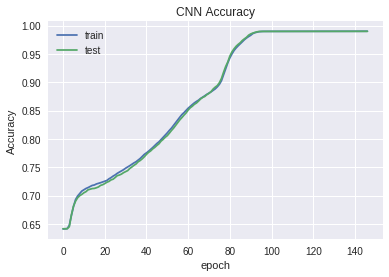

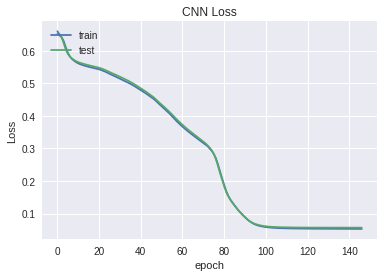

In [18]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('CNN Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
weight = model.get_weights()

In [20]:
weight

[array([[[-0.1503175 , -3.3643744 ],
         [-0.4481278 , -3.3513646 ],
         [ 0.13127594,  1.3491806 ],
         [-0.07985359, -3.1755412 ]],
 
        [[ 0.39440677,  1.5431892 ],
         [ 0.56211287, -2.9207153 ],
         [ 0.3539364 , -2.924101  ],
         [ 0.4303903 , -2.6446202 ]],
 
        [[-0.3468371 , -3.0839827 ],
         [-4.158147  , -3.8364277 ],
         [ 0.40372512, -2.6244917 ],
         [ 0.7780697 ,  1.4131159 ]],
 
        [[-3.9325087 ,  1.0591203 ],
         [-0.02425748, -3.541427  ],
         [ 1.4038478 , -2.983882  ],
         [-1.0363178 , -3.6354265 ]],
 
        [[ 1.4912182 ,  0.11009413],
         [-2.8413038 ,  0.25443944],
         [-1.4850321 ,  0.19963455],
         [ 0.13236213,  0.28196326]]], dtype=float32),
 array([-0.02849143, -0.9598825 ], dtype=float32),
 array([[[ 4.51535732e-01,  3.92175853e-01,  7.33746648e-01,
          -5.98251879e-01, -5.08669242e-02,  5.98438025e-01,
           7.96014905e-01, -1.51566684e-01,  7.02681363e-

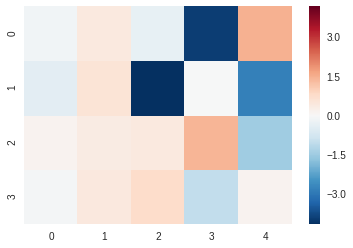

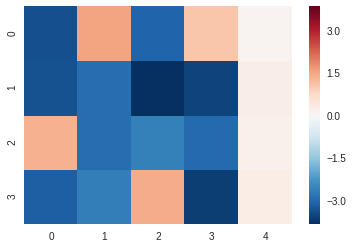

In [21]:
two_motifs = ['ATCAG','GGTCA']
convFilter = weight[0]
for i in range(2):
    ax = sns.heatmap(convFilter[:,:,i].T)
    plt.show()

In [29]:
convFilter[:,:]

array([[[ 4.34413701e-01, -1.33965582e-01,  1.27091244e-01,
         -3.55331451e-01, -4.58096713e-01, -3.12775195e-01,
          7.44358376e-02, -4.09540564e-01,  6.01754710e-02,
         -1.41212463e-01,  2.71943510e-01, -1.54645994e-01,
          3.48121524e-01,  7.08116591e-01, -3.58192325e-01],
        [ 3.39002460e-01, -1.23868138e-03, -1.80792674e-01,
         -2.25908309e-01, -4.86014217e-01, -1.43445146e+00,
          4.44749258e-02, -2.79777557e-01, -6.76830485e-02,
         -2.26458117e-01, -9.86696184e-02, -2.53193170e-01,
          5.22436917e-01, -6.51822686e-02, -4.59061027e-01],
        [-7.18326926e-01, -3.60219777e-02, -2.41651729e-01,
         -1.08763814e+00, -2.24255249e-02,  8.78957927e-01,
         -1.40164658e-01, -2.63199031e-01, -2.36755908e-01,
          3.80487949e-01, -2.34002545e-01, -6.34488225e-01,
          7.06466019e-01, -1.68957412e-01, -5.45369148e-01],
        [ 2.95617878e-01,  5.24301887e-01, -4.98794496e-01,
          5.93181908e-01, -6.51709497